# CliMA Vegetation model
---
Modules:

Compute leaf optical properties for standard values

Compute canopy radiation (both reflectance as well as within canopy distributions for SW energy balance)

Compute photosynthesis


In [1]:
# Add PATH (adapt!)
push!(LOAD_PATH, "/Users/braghier/Documents/CliMA/CliMA-land_copy/Land/src/Leaf/");
push!(LOAD_PATH, "/Users/braghier/Documents/CliMA/CliMA-land_copy/Land/src/Utils/");

# Canopy optical module
---
Fixed leaf optical properties within canopt (can be changed to vertical explicity approach later as in mSCOPE)


In [2]:
#Loading required modules
using PhysCon
using WaterVaporMod
using MathTools
using Leaf
using CanopyRTMod
using BenchmarkTools
using Statistics
using Plots

┌ Info: Precompiling PhysCon [top-level]
└ @ Base loading.jl:1273
┌ Info: Precompiling WaterVaporMod [top-level]
└ @ Base loading.jl:1273
┌ Info: Precompiling MathTools [top-level]
└ @ Base loading.jl:1273
┌ Warning: Module MathTools with build ID 99790507312435 is missing from the cache.
│ This may mean MathTools [top-level] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1011
┌ Info: Precompiling CanopyRTMod [top-level]
└ @ Base loading.jl:1273
┌ Warning: Module Leaf with build ID 99791047511914 is missing from the cache.
│ This may mean Leaf [top-level] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1011
┌ Info: Skipping precompilation since __precompile__(false). Importing CanopyRTMod [top-level].
└ @ Base loading.jl:1028


Reading Optical Parameters from 400.0 to 2380.0 length: 115


┌ Warning: Use of `Poly` from v1.0 forward will require `using Polynomials.PolyCompat`
│   caller = Polynomials.PolyCompat.Poly(::Array{Float32,1}) at Poly.jl:26
└ @ Polynomials.PolyCompat /Users/braghier/.julia/packages/Polynomials/ghqdF/src/polynomials/Poly.jl:26
┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1273
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


# Run Fluspect

Leaf optical property generator (provides reflectance and transmittance)

---

INPUT: 

1) optis = optipar{typ}(loadOpti(swl)...);

A list of input variables related to leaf biological status is defined in PhotoStructs.jl, including:     

    "Leaf structure parameter"
    N::FT    = 1.5       # | -          | (1.0, 3.0)  | "Leaf structure parameter"
    "Chlorophyll a+b content"
    Cab::FT  = 40.0      # | μg cm^-2   | (0.0, 110)  | "Chlorophyll a+b content"
    "Carotenoid content"
    Car::FT  = 10.0      # | μg cm^-2   | (0.0, 40.0) | "Carotenoid content"
    "Anthocynanin content"
    Ant::FT  = 8.0       # | μg cm^-2   | (0.0, 40.0) | "Anthocynanin content"
    "Senescent material fraction"
    Cs::FT   = 0.0       # | -          | (0.0, 1.0)  | "Senescent material fraction"
    "Equivalent water thickness"
    Cw::FT   = 0.015     # | cm         | (0.0, 0.05) | "Equivalent water thickness"
    "Dry matter content (dry leaf mass per unit area)"
    Cm::FT   = 0.01      # | g cm^-2    | (0.0, 0.2)  | "Dry matter content (dry leaf mass per unit area)"
    "Fractionation between Zeaxanthin and Violaxanthin in Car (1=all Zeaxanthin)"
    Cx::FT   = 0.0       # | -          | (0.0, 1.0)  | "Fractionation between Zeaxanthin and Violaxanthin in Car (1=all Zeaxanthin)"
    "Broadband thermal reflectance"
    ρ_LW::FT = 0.01      # | -          | (0.0, 1.0)  | "Broadband thermal reflectance"
    "Broadband thermal transmission"
    τ_LW::FT = 0.01      # | -          | (0.0, 1.0)  | "Broadband thermal transmission"
    "Leaf fluorescence efficiency"
    fqe::FT = 0.01       # | -          | (0.0, 1.0)  | "Leaf fluorescence efficiency"
    
OUTPUT:

2) leaf   = leafbio{typ}(ρ_SW=similar(wl),τ_SW=similar(wl), kChlrel=similar(wl), Mb=zeros(typ,length(wle), length(wlf)), Mf=zeros(typ,length(wle), length(wlf)) );

    " leaf reflectance"
    ρ_SW::Array{FT,1}    # | -          | (0.0, 1.0)  | " leaf reflectance"
    
    " leaf transmittance"
    τ_SW::Array{FT,1}    # | -          | (0.0, 1.0)  | " leaf transmittance"
    
    "relative absorption by Chlorophyll"
    kChlrel::Array{FT,1} # | -          | (0.0, 1.0)  | "relative absorption by Chlorophyll"
    
    "Fluorescence excitation matrix backwards"
    Mb::Array{FT,2}      # | -          | (0.0, 1.0)  | "Fluorescence excitation matrix backwards"
    
    "Fluorescence excitation matrix forwards"
    Mf::Array{FT,2}      # | -          | (0.0, 1.0)  | "Fluorescence excitation matrix forwards"


In [3]:
wl = CanopyRTMod.wl;
wle = CanopyRTMod.wle;
wlf = CanopyRTMod.wlf;

arrayOfLeaves = Array{leafbio{FT,length(wl), length(wle), length(wlf),length(wle)*length(wlf)}, 1}(undef, CanopyRTMod.canopy.nlayers)
for i = 1:CanopyRTMod.canopy.nlayers
    #@show i
    arrayOfLeaves[i] = leafbio{FT, length(wl), length(wle), length(wlf),length(wle)*length(wlf)}()
    @time CanopyRTMod.fluspect!(arrayOfLeaves[i], CanopyRTMod.optis)
end

#How long does Fluspect take to run per layer? 
@time CanopyRTMod.fluspect!(leaf, CanopyRTMod.optis)
@time CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt)
@time CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);

106.310779 seconds (135.84 M allocations: 5.026 GiB, 2.27% gc time)
  0.000768 seconds (3.10 k allocations: 996.719 KiB)
  0.000657 seconds (3.10 k allocations: 996.719 KiB)
  0.000631 seconds (3.10 k allocations: 996.719 KiB)
  0.000626 seconds (3.10 k allocations: 996.719 KiB)
  0.000652 seconds (3.10 k allocations: 996.719 KiB)
  0.000681 seconds (3.10 k allocations: 996.719 KiB)
  0.000688 seconds (3.10 k allocations: 996.719 KiB)
  0.000685 seconds (3.10 k allocations: 996.719 KiB)
  0.001050 seconds (3.10 k allocations: 996.719 KiB)
  0.001011 seconds (3.10 k allocations: 996.719 KiB)
  0.000710 seconds (3.10 k allocations: 996.719 KiB)
  0.000676 seconds (3.10 k allocations: 996.719 KiB)
  0.000709 seconds (3.10 k allocations: 996.719 KiB)
  0.000690 seconds (3.10 k allocations: 996.719 KiB)
  0.000682 seconds (3.10 k allocations: 996.719 KiB)
  0.000694 seconds (3.10 k allocations: 996.719 KiB)
  0.000692 seconds (3.10 k allocations: 996.719 KiB)
  0.000673 seconds (3.10 k allo

# What are the spectral values of reflectance and transmittance?

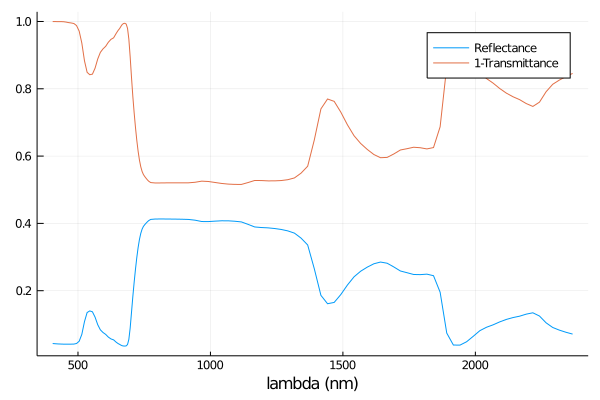

In [4]:
plot(CanopyRTMod.optis.lambda, leaf.ρ_SW, label="Reflectance")
plot!(CanopyRTMod.optis.lambda, 1 .-leaf.τ_SW, label="1-Transmittance")
xlabel!("lambda (nm)")

## Canopy Radiative Transfer module  

An adapted version of PRO-SAIL with PROSPECT-D but also adding within canopy radiation via SCOPE

---

INPUT:

FluspectMod.leaf -> Leaf optical properties (see Fluspect variables)

FluspectMod.canopy -> Canopy structural properties

    "number of canopy layers"
    nlayers::Int64     = 20    # | -          | (2, 60)      | "number of canopy layers"
    "Leaf Area Index"
    LAI::FT            = 3.0   # | -          | (0.0, 9.0)   | "Leaf Area Index"
    "Clumping factor"
    Ω::FT             = 1.0   # | -          | (0.0, 1.0)   | "clumping factor"
    "Leaf width"
    leafwidth::FT      = 0.1   # | m          | (0.0, 1.0)   | "Leaf width"
    "Vegetation height"
    hc::FT             = 2.0   # | m          | (0.0, 70.0)  | "Vegetation height"
    "Leaf Inclination"
    LIDFa::FT          = -0.35 # | -          | (-1.0, 1.0)  | "Leaf Inclination"
    "Variation in leaf inclination"
    LIDFb::FT          = -0.15 # | -          | (-1.0, 1.0)  | "Variation in leaf inclination"
    "HotSpot parameter (still need to check!)"
    hot::FT            = 0.05  # | -          | (0, 1.0)     | "HotSpot parameter (still need to check!)"
    "Leaf distribution type (2=campbell, 1=ladgen)"
    TypeLidf::FT       = 1     # | -          | (-1.0, 1.0)  | "Leaf distribution type (2=campbell, 1=ladgen)"
    "leaf azimuth angles relative to the sun"
    lazitab::Array{FT} = collect(5.0:10.0:355.0)
    
FluspectMod.angle -> Sun/Observation angular properties

    "Solar Zenith Angle in degrees"
    tts::FT=45
    "Viewing Zenith Angle in degrees"
    tto::FT=0
    "relative azimuth in degrees"
    psi::FT=0
    
FluspectMod.sunRad -> Incoming Shortwave Radiation (read from test case now, but coming from the atmosphere later on)

    "Spectral direct radiation at top of canopy"
    Edir =  suni["Edirect"]
    "Spectral direct radiation at top of canopy"
    Ediff =  suni["Ediffuse"]


### How does the Incoming Shortwave Radiation spectral curve look like?

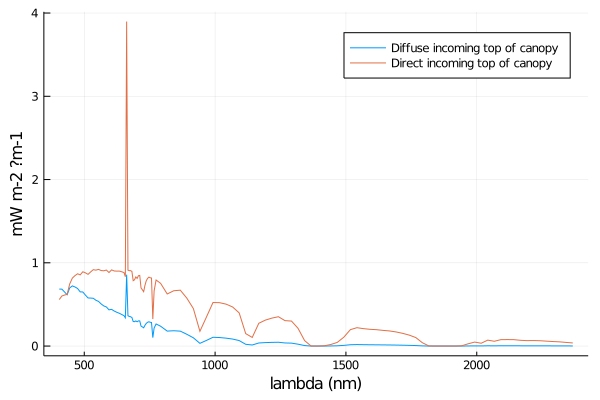

In [106]:
plot(CanopyRTMod.wl,CanopyRTMod.sunRad.E_diffuse, label="Diffuse incoming top of canopy")
plot!(CanopyRTMod.wl,CanopyRTMod.sunRad.E_direct, label="Direct incoming top of canopy")
ylabel!("mW m-2 μm-1")
xlabel!("lambda (nm)")

OUTPUT:

    "integrated TOC outgoing flux"
    intEout::FT                       # | W m^-2               | (0.0, 2500)  | "integrated TOC outgoing flux"
    "incident spectrally integrated total PAR"
    PAR::FT                           # | moles m^-2 s^-1      | (0.0, 2.5e-9)| "incident spectrally integrated total PAR"
    "incident spectrally integrated direct PAR"
    PAR_direct::FT                    # | moles m^-2 s^-1      | (0.0, 2.5e-9)| "incident spectrally integrated direct PAR"
    "incident spectrally integrated diffuse PAR"
    PAR_diffuse::FT                   # | moles m^-2 s^-1      | (0.0, 2.5e-9)| "incident spectrally integrated diffuse PAR"
    "net radiation of shaded soil"
    Rnhs::FT                          # | W m^-2               | (0.0, 2500)  | "net radiation of shaded soil"
    "net radiation of sunlit soil"
    Rnus::FT                          # | W m^-2               | (0.0, 2500)  | "net radiation of sunlit soil"
    "extinction cofficient in the solar direction"
    k::FT
    "extinction cofficient in the viewing direction"
    K::FT

    # Dim of nLayers+1
    "gap fraction in the solar direction"
    Ps::Array{FT,1}
    "gap fraction in the viewing direction"
    Po::Array{FT,1}
    "bi-derectional gap fraction (solar->canopy->viewing)"
    Pso::Array{FT,1}

    # Dim of nLayers
    "net radiation of shaded leaves"
    Rnhc::Array{FT,1}                 # | W m^-2               | (0.0, 2500)  | "net radiation of shaded leaves"
    "net PAR of shaded leaves"
    Pnh::Array{FT,1}                  # | moles m^-2 s^-1      | (0.0, 2.5e-9)| "net PAR of shaded leaves"
    "net PAR absorbed by Cab of shaded leaves"
    Pnh_Cab::Array{FT,1}              # | moles m^-2 s^-1      | (0.0, 2.5e-9)| "net PAR absorbed by Cab of shaded leaves"
    "net PAR absorbed by shaded leaves"
    Rnh_PAR::Array{FT,1}              # | W m^-2               | (0.0, 2500)  | "net PAR absorbed by shaded leaves

    # Dimension of wavelength only:
    "TOC outgoing radiance in observation direction"
    Lo::Array{FT,1}                   # | mW m^-2 μm^-1 sr^-1  | (0.0, 2500)  | "TOC outgoing radiance in observation direction"
    "TOC outgoing radiation"
    Eout::Array{FT,1}                 # | mW m^-2 μm^-1        | (0.0, 2500)  | "TOC outgoing radiation"
    "incident direct radiation at top of canopy"
    inc_SW_direct::Array{FT,1}        # | mW m^-2 μm^-1        | (0.0, 2500)  | "incident direct radiation at top of canopy"
    "incident diffuse radiation at top of canopy"
    inc_SW_diffuse::Array{FT,1}       # | mW m^-2 μm^-1        | (0.0, 2500)  | "incident diffuse radiation at top of canopy"
    "Albedo for direct incoming radiation"
    alb_direct::Array{FT,1}           # | -                    | (0.0, 1.0)   | "Albedo for direct incoming radiation"
    "Albedo for diffuse incoming radiation"
    alb_diffuse::Array{FT,1}          # | -                    | (0.0, 1.0)   | "Albedo for diffuse incoming radiation"


    # Dimension of nLayer+1 * nWavelengths
    "upwelling diffuse radiation within canopy"
    E_up::Array{FT,2}                 # | mW m^-2 μm^-1        | (0.0, 2500)  | "upwelling diffuse radiation within canopy"
    "downwelling diffuse radiation within canopy"
    E_down::Array{FT,2}               # | mW m^-2 μm^-1        | (0.0, 2500)  | "downwelling diffuse radiation within canopy"

    # Dimension of nLeafInclination * nLeafAzimuth * nLayer
    "net radiation of sunlit leaves"
    Rnuc::Array{FT,3}                 # | W m^-2               | (0.0, 2500)  | "net radiation of sunlit leaves"
    "net PAR of sunlit leaves"
    Pnu::Array{FT,3}                  # | moles m^-2 s^-1      | (0.0, 2.5e-9)| "net PAR of sunlit leaves"
    "net PAR absorbed by Cab of sunlit leaves"
    Pnu_Cab::Array{FT,3}              # | moles m^-2 s^-1      | (0.0, 2.5e-9)| "net PAR absorbed by Cab of sunlit leaves"
    "net PAR absorbed by sunlit leaves"
    Rnu_PAR::Array{FT,3}              # | W m^-2               | (0.0, 2500)  | "net PAR absorbed by sunlit leaves"


In [21]:
#How long does RTM_sail take to run? 
#can::struct_canopy, cO::struct_canopyOptProps, cR::struct_canopyRadiation, sun::incomingRadiation, so::struct_soil
@time CanopyRTMod.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil)

 77.029668 seconds (89.60 M allocations: 3.112 GiB, 2.29% gc time)


114-element StaticArrays.MArray{Tuple{114},Float32,1,114} with indices SOneTo(114):
 0.016298749
 0.016061665
 0.015881296
 0.015751388
 0.015681438
 0.015838094
 0.016197663
 0.016449228
 0.016857475
 0.018737108
 0.024835993
 0.04085269 
 0.06982264 
 ⋮          
 0.09234707 
 0.100015655
 0.10604642 
 0.11084376 
 0.11775029 
 0.12267599 
 0.11349179 
 0.09381508 
 0.08082256 
 0.07373846 
 0.067999184
 0.063178934

### How does canopy albedo look like?

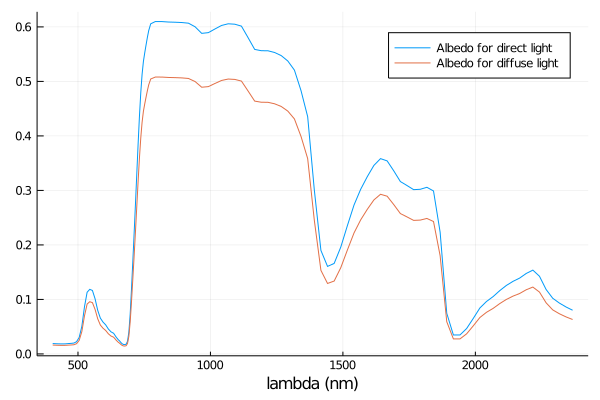

In [22]:
plot(CanopyRTMod.wl,CanopyRTMod.canRad.alb_direct, label="Albedo for direct light")
plot!(CanopyRTMod.wl,CanopyRTMod.canRad.alb_diffuse, label="Albedo for diffuse light")
xlabel!("lambda (nm)")

### What is the value of transmitted radiation reaching the soil?

Soil is still defined as polynomial (depends on state vector size), still TBD in the structure mode. Currently:

    pSoil =  Polynomials.Poly(typ(0.2))
    rsoil = Polynomials.polyval(pSoil,wl.-mean(wl));
    soil_emissivity = 1 .-rsoil # emissivity of soil (goes into structure later)

In [50]:
@time CanopyRTMod.deriveCanopyFluxes!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil, arrayOfLeaves);

println("Net radiation diffuse soil  ", CanopyRTMod.canRad.RnSoil_diffuse)
println("Net radiation direct soil  ", CanopyRTMod.canRad.RnSoil_direct)
println("Net radiation soil  ", CanopyRTMod.canRad.RnSoil_direct+CanopyRTMod.canRad.RnSoil_diffuse)

  0.000177 seconds (590 allocations: 268.906 KiB)
Net radiation diffuse soil  12.201622
Net radiation direct soil  0.42350906
Net radiation soil  12.625131


### Leaf photosynthesis module

In [51]:
# Create a leaf structure
l = leaf_params{Float32}();
l2 = leaf_params{Float32}();
# Create a Flux structure
f = Leaf.fluxes{Float32}();

In [52]:
# initialize some reasonable values
f.je = 100;
f.gbc = 100;
f.gbv = 100;
f.ceair =1500;
f.eair = 1500;
#f.APAR = 500;
#vertical mean of net PAR absorbed by Cab of sunlit leaves"
APAR_sunlit = mean(CanopyRTMod.canOpt.Ps[1:end-1].*mean(CanopyRTMod.canRad.absPAR_sun*1e6, dims=1:2)[1,1,:]);  
#vertical mean of net PAR absorbed by Cab of shaded leaves"
APAR_shaded = mean((1 .- CanopyRTMod.canOpt.Ps[1:end-1]).*mean(CanopyRTMod.canRad.absPAR_shade*1e6, dims=1:2)[1,1,:]);  
f.APAR = APAR_sunlit + APAR_shaded
println("Sunlit absorbed PAR  ",APAR_sunlit)
println("Shaded absorbed PAR  ",APAR_shaded)
println("Total absorbed PAR  ",f.APAR)

Sunlit absorbed PAR  77.64748711845705
Shaded absorbed PAR  11.176980936149524
Total absorbed PAR  88.82447


In [53]:
l.Kn = 2.44

#Temperature em Celsius
Temp = 24.85

#How long does the leaf photosynthesis module take to run? 
@time Leaf.LeafPhotosynthesis(f,l,(Temp + 273.15),f.APAR);

  0.000055 seconds (244 allocations: 4.953 KiB)


### Get some PAR response curves

In [54]:
apar = Float32[]
gpp_sunlit_1  = Float32[]
gpp_shaded_1  = Float32[]
apar_ = Float32[]
gpp_sunlit_2  = Float32[]
gpp_shaded_2  = Float32[]
gpp_total_1  = Float32[]
gpp_total_2  = Float32[]
f.cair = 400
l.vcmax25 = 90
l.jmax25 = 90*1.9
l2.vcmax25 = 50
l2.jmax25 = 50*1.9


vertical_APAR_sunlit = CanopyRTMod.canOpt.Ps[1:end-1].*mean(CanopyRTMod.canRad.absPAR_sun*1e6, dims=1:2)[1,1,:]

vertical_APAR_shaded =(1 .- CanopyRTMod.canOpt.Ps[1:end-1]).*mean(CanopyRTMod.canRad.absPAR_shade*1e6, dims=1:2)[1,1,:] 

vertical_APAR = vertical_APAR_sunlit .+ vertical_APAR_shaded

#Sunlit
#for f.APAR in 0:10:1000
for f.APAR in vertical_APAR_sunlit
    Leaf.LeafPhotosynthesis(f,l,(Temp + 273.15),f.APAR);
    push!(apar, f.APAR)
    push!(gpp_sunlit_1, f.an)
    Leaf.LeafPhotosynthesis(f,l2,(Temp + 273.15),f.APAR);
    push!(apar_, f.APAR)
    push!(gpp_sunlit_2, f.an)
    #println(f.APAR, " ", f.ag, " ", f.an)
end

#Shaded
for f.APAR in vertical_APAR_shaded
    Leaf.LeafPhotosynthesis(f,l,(Temp + 273.15),f.APAR);
    push!(apar, f.APAR)
    push!(gpp_shaded_1, f.an)
    Leaf.LeafPhotosynthesis(f,l2,(Temp + 273.15),f.APAR);
    push!(apar_, f.APAR)
    push!(gpp_shaded_2, f.an)
    #println(f.APAR, " ", f.ag, " ", f.an)
end

gpp_total_1 = ( CanopyRTMod.canOpt.Ps[1:end-1]).*(gpp_sunlit_1) + (1 .-CanopyRTMod.canOpt.Ps[1:end-1].*(gpp_shaded_1))
gpp_total_2 = ( CanopyRTMod.canOpt.Ps[1:end-1]).*(gpp_sunlit_2) + (1 .-CanopyRTMod.canOpt.Ps[1:end-1].*(gpp_shaded_2))

20-element Array{Float32,1}:
 10.252056  
  7.7322383 
  5.8914466 
  4.190856  
  2.8156009 
  1.9760606 
  1.5102638 
  1.2587287 
  1.1252105 
  1.0557498 
  1.0206299 
  1.0036939 
  0.9962082 
  0.9934672 
  0.99300694
  0.9935877 
  0.9945495 
  0.99556506
  0.99648917
  0.99727076

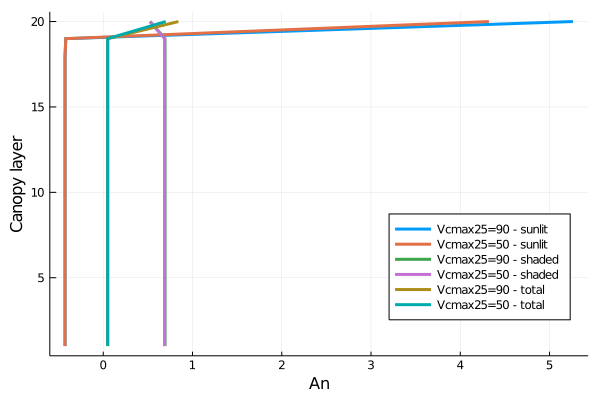

In [107]:
# Test the impact of Vcmax on vertical photosynthesis
plot(reverse(gpp_sunlit_1),[1:1:CanopyRTMod.canopy.nlayers],lw=3, label="Vcmax25=90 - sunlit", ylabel="Canopy layer", xlabel="An")
plot!(reverse(gpp_sunlit_2),[1:1:CanopyRTMod.canopy.nlayers],lw=3, label="Vcmax25=50 - sunlit")
plot!(reverse(gpp_shaded_1),[1:1:CanopyRTMod.canopy.nlayers],lw=3, label="Vcmax25=90 - shaded")
plot!(reverse(gpp_shaded_2),[1:1:CanopyRTMod.canopy.nlayers],lw=3, label="Vcmax25=50 - shaded")
plot!(reverse(gpp_total_1),[1:1:CanopyRTMod.canopy.nlayers],lw=3, label="Vcmax25=90 - total")
plot!(reverse(gpp_total_2),[1:1:CanopyRTMod.canopy.nlayers],lw=3, label="Vcmax25=50 - total",legend=:bottomright)


### Get some PAR response curves

In [29]:
print("Vcmax25=90","Total GPP =",sum(gpp_total_1)./CanopyRTMod.canopy.nlayers,"\n")
print("Vcmax25=50","Total GPP =",sum(gpp_total_2)./CanopyRTMod.canopy.nlayers)

Vcmax25=90Total GPP =3.0430434
Vcmax25=50Total GPP =2.3896337

In [30]:
# Test T dependence
T_ = Float32[]
ag_T_  = Float32[]
an_T_  = Float32[]
vcmax_T_  = Float32[]
electron_co2_T_  = Float32[]
gamma_T_  = Float32[]
#f.APAR = 500
f.APAR = APAR_sunlit + APAR_shaded

for T in 260:1:320
    Leaf.LeafPhotosynthesis(f,l,T,f.APAR);
    push!(T_, T)
    push!(ag_T_, f.ag)
    push!(an_T_, f.an)
    push!(vcmax_T_, l.vcmax)
    push!(electron_co2_T_, l.CO2_per_electron)
    push!(gamma_T_ , l.Γstar)
end

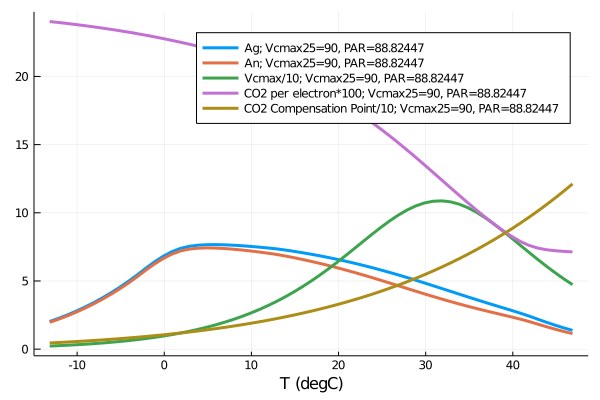

In [31]:
m = f.APAR
plot(T_.-273.15, ag_T_, lw=3, label="Ag; Vcmax25=90, PAR=$m",  xlabel="T (degC)")
plot!(T_.-273.15, an_T_, lw=3, label="An; Vcmax25=90, PAR=$m")
plot!(T_.-273.15, vcmax_T_/10, lw=3, label="Vcmax/10; Vcmax25=90, PAR=$m")
plot!(T_.-273.15, electron_co2_T_*100, lw=3, label="CO2 per electron*100; Vcmax25=90, PAR=$m")
plot!(T_.-273.15, gamma_T_/10, lw=3, label="CO2 Compensation Point/10; Vcmax25=90, PAR=$m")

## Simulating photosynthesis in SSA-OA

In [6]:
using DataFrames, CSV

#CSV.read("/Users/braghier/Desktop/SSA_OA_input.csv"; header=true)

f1 = CSV.read("/Users/braghier/Desktop/SSA_OA_input.csv"; header=true)


┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1273
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1273


thread = 1 warning: only found 10 / 11 columns on data row: 637. Filling remaining columns with `missing`


,DATE,Tair,VPD,PAR,SW,Press,DIF,NEE,RECO
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,7/11/96 1:00,14.9,1.79,27.62,60.94,936.99,0.05,-0.85,6.64
2,7/11/96 1:30,14.87,1.26,17.93,39.64,936.83,0.04,-1.21,6.6
3,7/11/96 2:00,15.02,0.79,20.37,46.11,936.8,0.09,-3.03,6.54
4,7/11/96 2:30,15.1,1.1,12.7,29.38,936.71,0.1,-3.41,6.51
5,7/11/96 3:00,14.98,1.44,6.92,16.41,936.83,0.29,-2.19,6.51
6,7/11/96 3:30,14.92,0.58,1.27,3.02,936.97,0.14,-5.21,6.48
7,7/11/96 4:00,14.87,0.43,0.23,0.38,937.14,0.06,-5.41,5.41
8,7/11/96 4:30,14.89,0.49,0.02,0.07,937.28,0.06,-5.61,5.61
9,7/11/96 5:00,14.94,1.25,0.0,0.12,937.55,0.06,-5.81,5.81


In [8]:
arrayOfLeaves = Array{leafbio{FT,length(wl), length(wle), length(wlf),length(wle)*length(wlf)}, 1}(undef, CanopyRTMod.canopy.nlayers)
for i = 1:CanopyRTMod.canopy.nlayers
    #@show i
    arrayOfLeaves[i] = leafbio{FT, length(wl), length(wle), length(wlf),length(wle)*length(wlf)}()
    CanopyRTMod.fluspect!(arrayOfLeaves[i], CanopyRTMod.optis)
end

SW_dif = sunRad.E_diffuse[:]
SW_dir = sunRad.E_direct[:]

114-element Array{Float32,1}:
 423.91205 
 456.2974  
 464.9233  
 470.93362 
 566.8391  
 619.44336 
 641.89233 
 658.91205 
 648.7285  
 677.19165 
 667.3115  
 653.706   
 675.8207  
   ⋮       
  58.318916
  59.031662
  58.342964
  52.554035
  49.43001 
  50.346333
  48.508892
  44.747684
  41.09356 
  38.33341 
  33.06685 
  28.3946  

In [121]:

GPP_1 = []
GPP_2 = []
GPP_obs = []


#for i=12:1:72
for i=12:1:72+90

if rad2deg(acos(f1.COSSZA[i])) < 90.
   CanopyRTMod.angles.tts = rad2deg(acos(f1.COSSZA[i]));
else
   CanopyRTMod.angles.tts = 89.9;
end 
    
CanopyRTMod.soil.albedo_SW[:] .=0.11;
CanopyRTMod.canopy.LAI = 4.6
CanopyRTMod.canopy.Ω = 1.0



#sunRad.E_diffuse[28] = f1.PAR[i].*f1.DIF[i].*100.
#sunRad.E_direct[28] = f1.PAR[i].*100.
    
frac = f1.SW[i]./(mean(SW_dir) .+ mean(SW_dif))
sunRad.E_diffuse = SW_dif.*frac
sunRad.E_direct = SW_dir.*frac 

    
CanopyRTMod.fluspect!(leaf, CanopyRTMod.optis)
CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt)
CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);

# Create a leaf structure

l = leaf_params{Float32}();
l2 = leaf_params{Float32}();

# Create a Flux structure

f = Leaf.fluxes{Float32}();

# initialize some reasonable values

f.je = 100;
f.gbc = 100;
f.gbv = 100;
f.ceair = f1.VPD[i].*100.;
f.eair = f1.VPD[i].*100.;


#vertical mean of net PAR absorbed by Cab of sunlit leaves"

APAR_sunlit = mean(CanopyRTMod.canOpt.Ps[1:end-1].*mean(CanopyRTMod.canRad.absPAR_sun*1e6, dims=1:2)[1,1,:]);  

#vertical mean of net PAR absorbed by Cab of shaded leaves"

APAR_shaded = mean((1 .- CanopyRTMod.canOpt.Ps[1:end-1]).*mean(CanopyRTMod.canRad.absPAR_shade*1e6, dims=1:2)[1,1,:]);  
f.APAR = APAR_sunlit + APAR_shaded

l.Kn = 2.44

#Temperature em Celsius
Temp = f1.Tair[i];

apar = Float32[]
gpp_sunlit_1  = Float32[]
gpp_shaded_1  = Float32[]
apar_ = Float32[]
gpp_sunlit_2  = Float32[]
gpp_shaded_2  = Float32[]
gpp_total_1  = Float32[]
gpp_total_2  = Float32[]
f.cair = 380
l.vcmax25 = 45
l.jmax25 = 45*1.9
l2.vcmax25 = 25
l2.jmax25 = 25*1.9


vertical_APAR_sunlit = CanopyRTMod.canOpt.Ps[1:end-1].*mean(CanopyRTMod.canRad.absPAR_sun*1e6, dims=1:2)[1,1,:]
vertical_APAR_shaded =(1 .- CanopyRTMod.canOpt.Ps[1:end-1]).*mean(CanopyRTMod.canRad.absPAR_shade*1e6, dims=1:2)[1,1,:] 
vertical_APAR = vertical_APAR_sunlit .+ vertical_APAR_shaded

#Sunlit
for f.APAR in vertical_APAR_sunlit
    Leaf.LeafPhotosynthesis(f,l,(Temp + 273.15),f.APAR);
    push!(apar, f.APAR)
    push!(gpp_sunlit_1, f.an)
    Leaf.LeafPhotosynthesis(f,l2,(Temp + 273.15),f.APAR);
    push!(apar_, f.APAR)
    push!(gpp_sunlit_2, f.an)
    #println(f.APAR, " ", f.ag, " ", f.an)
end

#Shaded
for f.APAR in vertical_APAR_shaded
    Leaf.LeafPhotosynthesis(f,l,(Temp + 273.15),f.APAR);
    push!(apar, f.APAR)
    push!(gpp_shaded_1, f.an)
    Leaf.LeafPhotosynthesis(f,l2,(Temp + 273.15),f.APAR);
    push!(apar_, f.APAR)
    push!(gpp_shaded_2, f.an)
end

gpp_total_1 = ( CanopyRTMod.canOpt.Ps[1:end-1]).*(gpp_sunlit_1) + (1 .-CanopyRTMod.canOpt.Ps[1:end-1].*(gpp_shaded_1))./CanopyRTMod.canopy.nlayers
gpp_total_2 = ( CanopyRTMod.canOpt.Ps[1:end-1]).*(gpp_sunlit_2) + (1 .-CanopyRTMod.canOpt.Ps[1:end-1].*(gpp_shaded_2))./CanopyRTMod.canopy.nlayers
    
push!(GPP_1, sum(gpp_total_1))
push!(GPP_2, sum(gpp_total_2))
push!(GPP_obs, f1.GPP[i])
    
print(f1.GPP[i],"\t", sum(gpp_total_2),"\n")
end

0.0	1.001641
0.0	1.0017166
0.0	1.0017068
0.0	1.0017922
0.0	1.0017211
0.0	1.0016924
0.0	1.0016311
0.0	1.001703
0.0	1.0018022
3.79	1.6540382
4.72	3.9707024
7.46	6.4829164
10.47	9.046558
10.67	11.693302
13.23	14.397043
19.52	17.455538
21.64	20.756193
25.88	24.043058
22.11	27.219091
27.43	29.788355
23.19	32.122856
30.13	34.270744
26.14	35.780796
18.82	36.808857
23.83	37.485077
22.49	37.78602
31.0	37.548985
25.58	36.890694
23.27	35.92003
17.71	34.57487
13.34	32.94067
11.9	31.005924
19.21	28.524591
17.32	25.937567
23.69	23.269617
10.41	20.161352
10.53	17.023382
11.64	13.932643
9.19	10.930367
2.56	7.9584537
0.82	5.1167192
2.95	2.4741387
2.18	1.0002048
0.0	1.0003382
0.0	1.0005372
0.0	1.0006438
0.0	1.0007449
0.0	1.0008407
0.0	1.000961
0.0	1.0013322
0.0	1.0014102
0.0	1.0016842
0.0	1.0017067
0.0	1.0017546
0.0	1.0018373
0.0	1.0016599
0.0	1.0017787
-2.91	1.3005608
-5.51	2.4645984
5.12	4.190609
4.48	5.997138
8.62	7.557066
12.84	9.672384
12.12	13.189751
18.74	17.611923
25.79	20.907598
25.92	24.212097

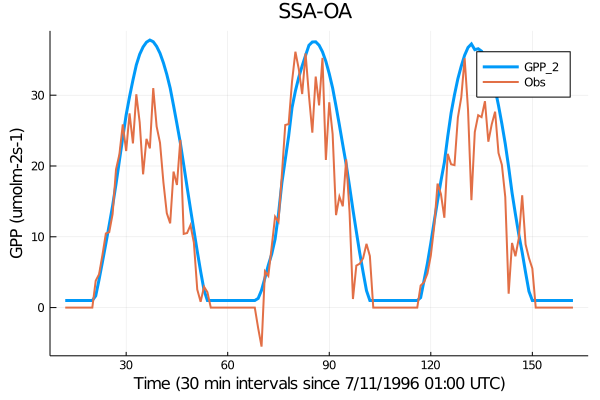

In [130]:
i=12:1:72+90

#plot(i, GPP_1,label="GPP_1")
plot(i, GPP_2,label="GPP_2",title = "SSA-OA ",lw = 3)
plot!(i, GPP_obs,label="Obs",lw = 2)


ylabel!("GPP (umolm-2s-1)")
xlabel!("Time (30 min intervals since 7/11/1996 01:00 UTC)")
#plot!(xlims = (0.0, 90.), ylims = (-0.05, 1.0), xticks = 0:20:91., yticks = 0:0.2:1.0)